In [3]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [4]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import shap

ModuleNotFoundError: No module named 'shap'

In [6]:
from catboost import CatBoostClassifier, metrics
from src.utils.utils import get_feat_names, BAND_LIMITS_POW, BAND_LIMITS_POW_PH

In [7]:
ELM19_info_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_info_filtered_norm.csv'
ELM19_features_filtered_norm_path = 'datasets/ELM19/filtered/ELM19_features_filtered_norm.csv'

In [6]:
save_path = f'results/tables'
os.makedirs(save_path, exist_ok=True)

In [7]:
df_info = pd.read_csv(ELM19_info_filtered_norm_path)
df_feats = pd.read_csv(ELM19_features_filtered_norm_path)

NameError: name 'ELM19_info_filtered_norm_path' is not defined

In [8]:
df_feats.info()

NameError: name 'df_feats' is not defined

In [ ]:
df_info.info()

In [17]:
X = df_feats
y = df_info['institution_id']

In [19]:
def get_scores(y_true, y_prob, label_encoder):
    y_pred = label_encoder.inverse_transform(np.argmax(y_prob, axis=1))  # Get predicted class labels

    scores = {"MCC_Overall": matthews_corrcoef(y_true, y_pred),
              "Accuracy": accuracy_score(y_true, y_pred),
              "Precision (Macro)": precision_score(y_true, y_pred, average="macro", zero_division=0),
              "Precision (Weighted)": precision_score(y_true, y_pred, average="weighted", zero_division=0),
              "Recall (Macro)": recall_score(y_true, y_pred, average="macro", zero_division=0),
              "Recall (Weighted)": recall_score(y_true, y_pred, average="weighted", zero_division=0),
              "F1-Score (Macro)": f1_score(y_true, y_pred, average="macro", zero_division=0),
              "F1-Score (Weighted)": f1_score(y_true, y_pred, average="weighted", zero_division=0),
              "AUC (OvR)": roc_auc_score(y_true, y_prob, multi_class="ovr"),
              "AUC (OvO)": roc_auc_score(y_true, y_prob, multi_class="ovo")}

    mcc_per_class = {
        f"MCC_{cls}": matthews_corrcoef((y_true == cls).astype(int), (y_pred == cls).astype(int))
        for cls in label_encoder.inverse_transform(range(len(label_encoder.classes_)))
    }
    scores.update(mcc_per_class)

    return scores

def compute_confusion_matrix(y_true, y_prob, label_encoder):
    y_pred = label_encoder.inverse_transform(np.argmax(y_prob, axis=1))
    cm = confusion_matrix(y_true, y_pred, labels=label_encoder.inverse_transform(range(len(label_encoder.classes_))))

    return cm

In [20]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
hospital_names = label_encoder.inverse_transform(range(len(label_encoder.classes_)))

feature_names_list = df_feats.columns

In [21]:
feature_groups_A = {
    "coh": [col for col in df_feats.columns if col.startswith("coh")],
    "pow": [col for col in df_feats.columns if col.startswith("pow")],
    "cov": [col for col in df_feats.columns if col.startswith("cov")]
}

feature_groups_B = {}
for group_name, features in feature_groups_A.items():
    if "pow" in group_name or "coh" in group_name:
        for f_low, f_high, band_name in BAND_LIMITS_POW:
            if f_low == 0.5:
                f_low = 0
            matching_features = [col for col in features if col.endswith(f"{int(float(f_low))}_{int(float(f_high))}")]

            if matching_features:
                feature_groups_B.setdefault(f"{group_name}_{band_name}", []).extend(matching_features)
    else:
        feature_groups_B[group_name] = features
print(feature_groups_B.keys())

dict_keys(['coh_delta', 'coh_theta', 'coh_alfa', 'coh_beta', 'coh_gamma', 'pow_delta', 'pow_theta', 'pow_alfa', 'pow_beta', 'pow_gamma', 'cov'])


In [77]:
for group_name, features in feature_groups_A.items():
    print(group_name, len(features))

coh 2394
pow 266
cov 190


In [ ]:
params = {'iterations': 2000,
          'learning_rate': 0.2136106733298358,
          'depth': 5.0,
          'l2_leaf_reg': 1.0050061307458207,
          'eval_metric': 'MultiClass',
          'task_type': "GPU"
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

for group_name, features in feature_groups_A.items():
    if group_name == 'coh':
        continue

    fold_metrics_list = []
    fold_confusion_matrices = {}
    all_y_true = []
    all_y_pred_proba = []
    all_shap_values = []
    for fold_num, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        logging.info(f"Starting fold {fold_num+1}/5")

        X_train, X_test = X.iloc[train_idx][features], X.iloc[test_idx][features]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        logging.info("Initializing the Catboost model...")
        model = CatBoostClassifier(**params)

        logging.info("Training the model...")
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)
        logging.info("Model training completed.")
    
        logging.info("Generating predictions...")
        y_prob = model.predict_proba(X_test)
        logging.info("Predictions generated successfully.")
    
        # 1. Get and store scores for the fold
        scores_fold = get_scores(y_test, y_prob, label_encoder)
        scores_fold['fold'] = fold_num + 1
        fold_metrics_list.append(scores_fold)
        logging.info(f"Results saved.")
    
        # 2. Get and store confusion matrix for the fold
        cm_fold = compute_confusion_matrix(y_test, y_prob, label_encoder)
        fold_confusion_matrices[f'fold_{fold_num+1}_cm'] = cm_fold
    
        # 3. Collect out-of-fold predictions
        all_y_true.extend(y_test)
        all_y_pred_proba.extend(y_prob)
    
        # 4. Shap
        logging.info("Computing SHAP values.")
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        for shap_val in shap_values:
            all_shap_values.append(shap_val)

    fold_metrics_df = pd.DataFrame(fold_metrics_list)
    fold_metrics_df.to_csv(os.path.join(save_path, f"{group_name}_cv_fold_metrics.csv"), index=False)
    logging.info("Fold metrics saved to cv_fold_metrics.csv")
    
    aggregated_metrics_mean = fold_metrics_df.drop(columns=['fold']).mean().to_frame('mean_value')
    aggregated_metrics_std = fold_metrics_df.drop(columns=['fold']).std().to_frame('std_value')
    aggregated_metrics_summary = pd.concat([aggregated_metrics_mean, aggregated_metrics_std], axis=1)
    aggregated_metrics_summary.to_csv(os.path.join(save_path, f"{group_name}_cv_aggregated_metrics_summary.csv"))
    logging.info("Aggregated metrics summary saved to cv_aggregated_metrics_summary.csv")
    
    np.savez_compressed(os.path.join(save_path, f"{group_name}_cv_fold_confusion_matrices.npz"), labels=hospital_names, **fold_confusion_matrices)
    logging.info(f"Fold confusion matrices saved to cv_fold_confusion_matrices.npz with labels: {hospital_names}")
    
    all_y_pred_proba_array = np.array(all_y_pred_proba)
    oof_df = pd.DataFrame(all_y_pred_proba_array, columns=[f"prob_{name}" for name in hospital_names])
    oof_df['true_label_name'] = all_y_true 
    oof_df.to_csv(os.path.join(save_path, f"{group_name}_cv_oof_predictions.csv"), index=False)
    logging.info("OOF predictions saved to cv_oof_predictions.csv")
    
    all_shap_values_array = np.array(all_shap_values)
    global_mean_abs_shap = np.mean(np.abs(all_shap_values_array), axis=0)
    global_mean_abs_shap_df = pd.DataFrame(
        global_mean_abs_shap.T,         
        index=hospital_names,              
        columns=features           
    )
    global_mean_abs_shap_df.to_csv(os.path.join(save_path, f"{group_name}_cv_global_shap_summary.csv"), index=False)
    logging.info("Global mean absolute SHAP data saved to cv_global_shap_summary.csv.")

In [ ]:
params = {'iterations': 2000,
          'learning_rate': 0.2136106733298358,
          'depth': 5.0,
          'l2_leaf_reg': 1.0050061307458207,
          'eval_metric': 'MultiClass',
          'task_type': "GPU"
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=100)

for group_name, features in feature_groups_A.items():
    if group_name == 'coh':
        continue
    fold_metrics_list = []
    fold_confusion_matrices = {}
    all_y_true = []
    all_y_pred_proba = []
    all_shap_values = []
    for fold_num, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        logging.info(f"Starting fold {fold_num+1}/5")

        X_train, X_test = X.iloc[train_idx, ~X.columns.isin(features)], X.iloc[test_idx, ~X.columns.isin(features)]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        logging.info("Initializing the Catboost model...")
        model = CatBoostClassifier(**params)

        logging.info("Training the model...")
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)
        logging.info("Model training completed.")
    
        logging.info("Generating predictions...")
        y_prob = model.predict_proba(X_test)
        logging.info("Predictions generated successfully.")
    
        # 1. Get and store scores for the fold
        scores_fold = get_scores(y_test, y_prob, label_encoder)
        scores_fold['fold'] = fold_num + 1
        fold_metrics_list.append(scores_fold)
        logging.info(f"Results saved.")
    
        # 2. Get and store confusion matrix for the fold
        cm_fold = compute_confusion_matrix(y_test, y_prob, label_encoder)
        fold_confusion_matrices[f'fold_{fold_num+1}_cm'] = cm_fold
    
        # 3. Collect out-of-fold predictions
        all_y_true.extend(y_test)
        all_y_pred_proba.extend(y_prob)
    
        # 4. Shap
        logging.info("Computing SHAP values.")
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test)
        for shap_val in shap_values:
            all_shap_values.append(shap_val)

    fold_metrics_df = pd.DataFrame(fold_metrics_list)
    fold_metrics_df.to_csv(os.path.join(save_path, f"excluded_{group_name}_cv_fold_metrics.csv"), index=False)
    logging.info("Fold metrics saved to cv_fold_metrics.csv")
    
    aggregated_metrics_mean = fold_metrics_df.drop(columns=['fold']).mean().to_frame('mean_value')
    aggregated_metrics_std = fold_metrics_df.drop(columns=['fold']).std().to_frame('std_value')
    aggregated_metrics_summary = pd.concat([aggregated_metrics_mean, aggregated_metrics_std], axis=1)
    aggregated_metrics_summary.to_csv(os.path.join(save_path, f"excluded_{group_name}_cv_aggregated_metrics_summary.csv"))
    logging.info("Aggregated metrics summary saved to cv_aggregated_metrics_summary.csv")
    
    np.savez_compressed(os.path.join(save_path, f"excluded_{group_name}_cv_fold_confusion_matrices.npz"), labels=hospital_names, **fold_confusion_matrices)
    logging.info(f"Fold confusion matrices saved to cv_fold_confusion_matrices.npz with labels: {hospital_names}")
    
    all_y_pred_proba_array = np.array(all_y_pred_proba)
    oof_df = pd.DataFrame(all_y_pred_proba_array, columns=[f"prob_{name}" for name in hospital_names])
    oof_df['true_label_name'] = all_y_true 
    oof_df.to_csv(os.path.join(save_path, f"excluded_{group_name}_cv_oof_predictions.csv"), index=False)
    logging.info("OOF predictions saved to cv_oof_predictions.csv")
    
    all_shap_values_array = np.array(all_shap_values)
    global_mean_abs_shap = np.mean(np.abs(all_shap_values_array), axis=0)
    global_mean_abs_shap_df = pd.DataFrame(
        global_mean_abs_shap.T,         
        index=hospital_names,              
        columns=feature_names_list[~X.columns.isin(features)]        
    )
    global_mean_abs_shap_df.to_csv(os.path.join(save_path, f"excluded_{group_name}_cv_global_shap_summary.csv"), index=False)
    logging.info("Global mean absolute SHAP data saved to cv_global_shap_summary.csv.")

# Analyze Results

In [41]:
fold_metrics_df = pd.read_csv(os.path.join(save_path, "cv_fold_metrics.csv"))
results_df_mean = fold_metrics_df.drop('fold', axis=1).mean(axis=0)
results_df_mean_MCC = results_df_mean[results_df_mean.index.str.startswith("MCC_")]
results_df_mean_MCC = results_df_mean_MCC.drop("MCC_Overall")
class_labels = results_df_mean_MCC.index.str.replace("MCC_", "", regex=False)

In [1]:
def save_and_show_results(feature_group='coh', method_type='selected'):
    if method_type == 'excluded':
        feature_group = f'excluded_{feature_group}'
        
    fold_metrics_df = pd.read_csv(os.path.join(save_path, f"{feature_group}_cv_fold_metrics.csv"))
    aggregated_metrics_summary = pd.read_csv(os.path.join(save_path, f"{feature_group}_cv_aggregated_metrics_summary.csv"))
    conf_matrices_data = np.load(os.path.join(save_path, f"{feature_group}_cv_fold_confusion_matrices.npz"), allow_pickle=True)

    print(aggregated_metrics_summary)

    hospital_names = list(conf_matrices_data.values())[0]
    conf_matrices = list(conf_matrices_data.values())[1:]
    mean_conf_matrix = np.sum(conf_matrices, axis=0)
    normalized_conf_matrix = mean_conf_matrix / mean_conf_matrix.sum(axis=1, keepdims=True)
    plt.figure(figsize=(20, 18))
    ax = sns.heatmap(
        normalized_conf_matrix,
        annot=True,
        fmt=".2f",
        cmap="Reds",
        linewidths=0.5,
        annot_kws={"size": 14},
        cbar=False
    )
    ax.set_xlabel("Predicted Label", fontsize=20)
    ax.set_ylabel("True Label", fontsize=20)
    #ax.set_title("Mean Normalized Confusion Matrix (across folds)")
    plt.xticks(rotation=90)
    ax.set_xticklabels(hospital_names, fontsize=15)
    plt.yticks(rotation=0)
    ax.set_yticklabels(hospital_names, fontsize=15)
    plt.tight_layout()
    plt.savefig(f'results/figures/{feature_group}_hospital_classification_avg_confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()

    results_df_mean = fold_metrics_df.drop('fold', axis=1).mean(axis=0)
    results_df_mean_MCC = results_df_mean.loc[results_df_mean.index.str.startswith("MCC_")]
    results_df_mean_MCC = results_df_mean_MCC.drop('MCC_Overall')
    results_df_mean_MCC = pd.DataFrame([results_df_mean_MCC.values], columns=results_df_mean_MCC.index)
    
    return results_df_mean_MCC
    

# Coh

              Unnamed: 0  mean_value  std_value
0            MCC_Overall    0.863086   0.003757
1               Accuracy    0.876317   0.003377
2      Precision (Macro)    0.862442   0.021898
3   Precision (Weighted)    0.872921   0.004498
4         Recall (Macro)    0.735301   0.010973
5      Recall (Weighted)    0.876317   0.003377
6       F1-Score (Macro)    0.769087   0.012356
7    F1-Score (Weighted)    0.867922   0.003869
8              AUC (OvR)    0.992011   0.000840
9              AUC (OvO)    0.987824   0.001133
10               MCC_AKS    0.513854   0.112846
11           MCC_ARCHDAM    0.867770   0.006037
12               MCC_B2K    0.937599   0.009751
13               MCC_CHE    0.421603   0.087787
14               MCC_CMD    0.208199   0.055026
15               MCC_GAK    0.753223   0.026824
16               MCC_KAL    0.931987   0.023113
17         MCC_KATMOJPRZ    0.919647   0.007467
18              MCC_KIEG    0.421475   0.039643
19               MCC_KLU    0.821397   0

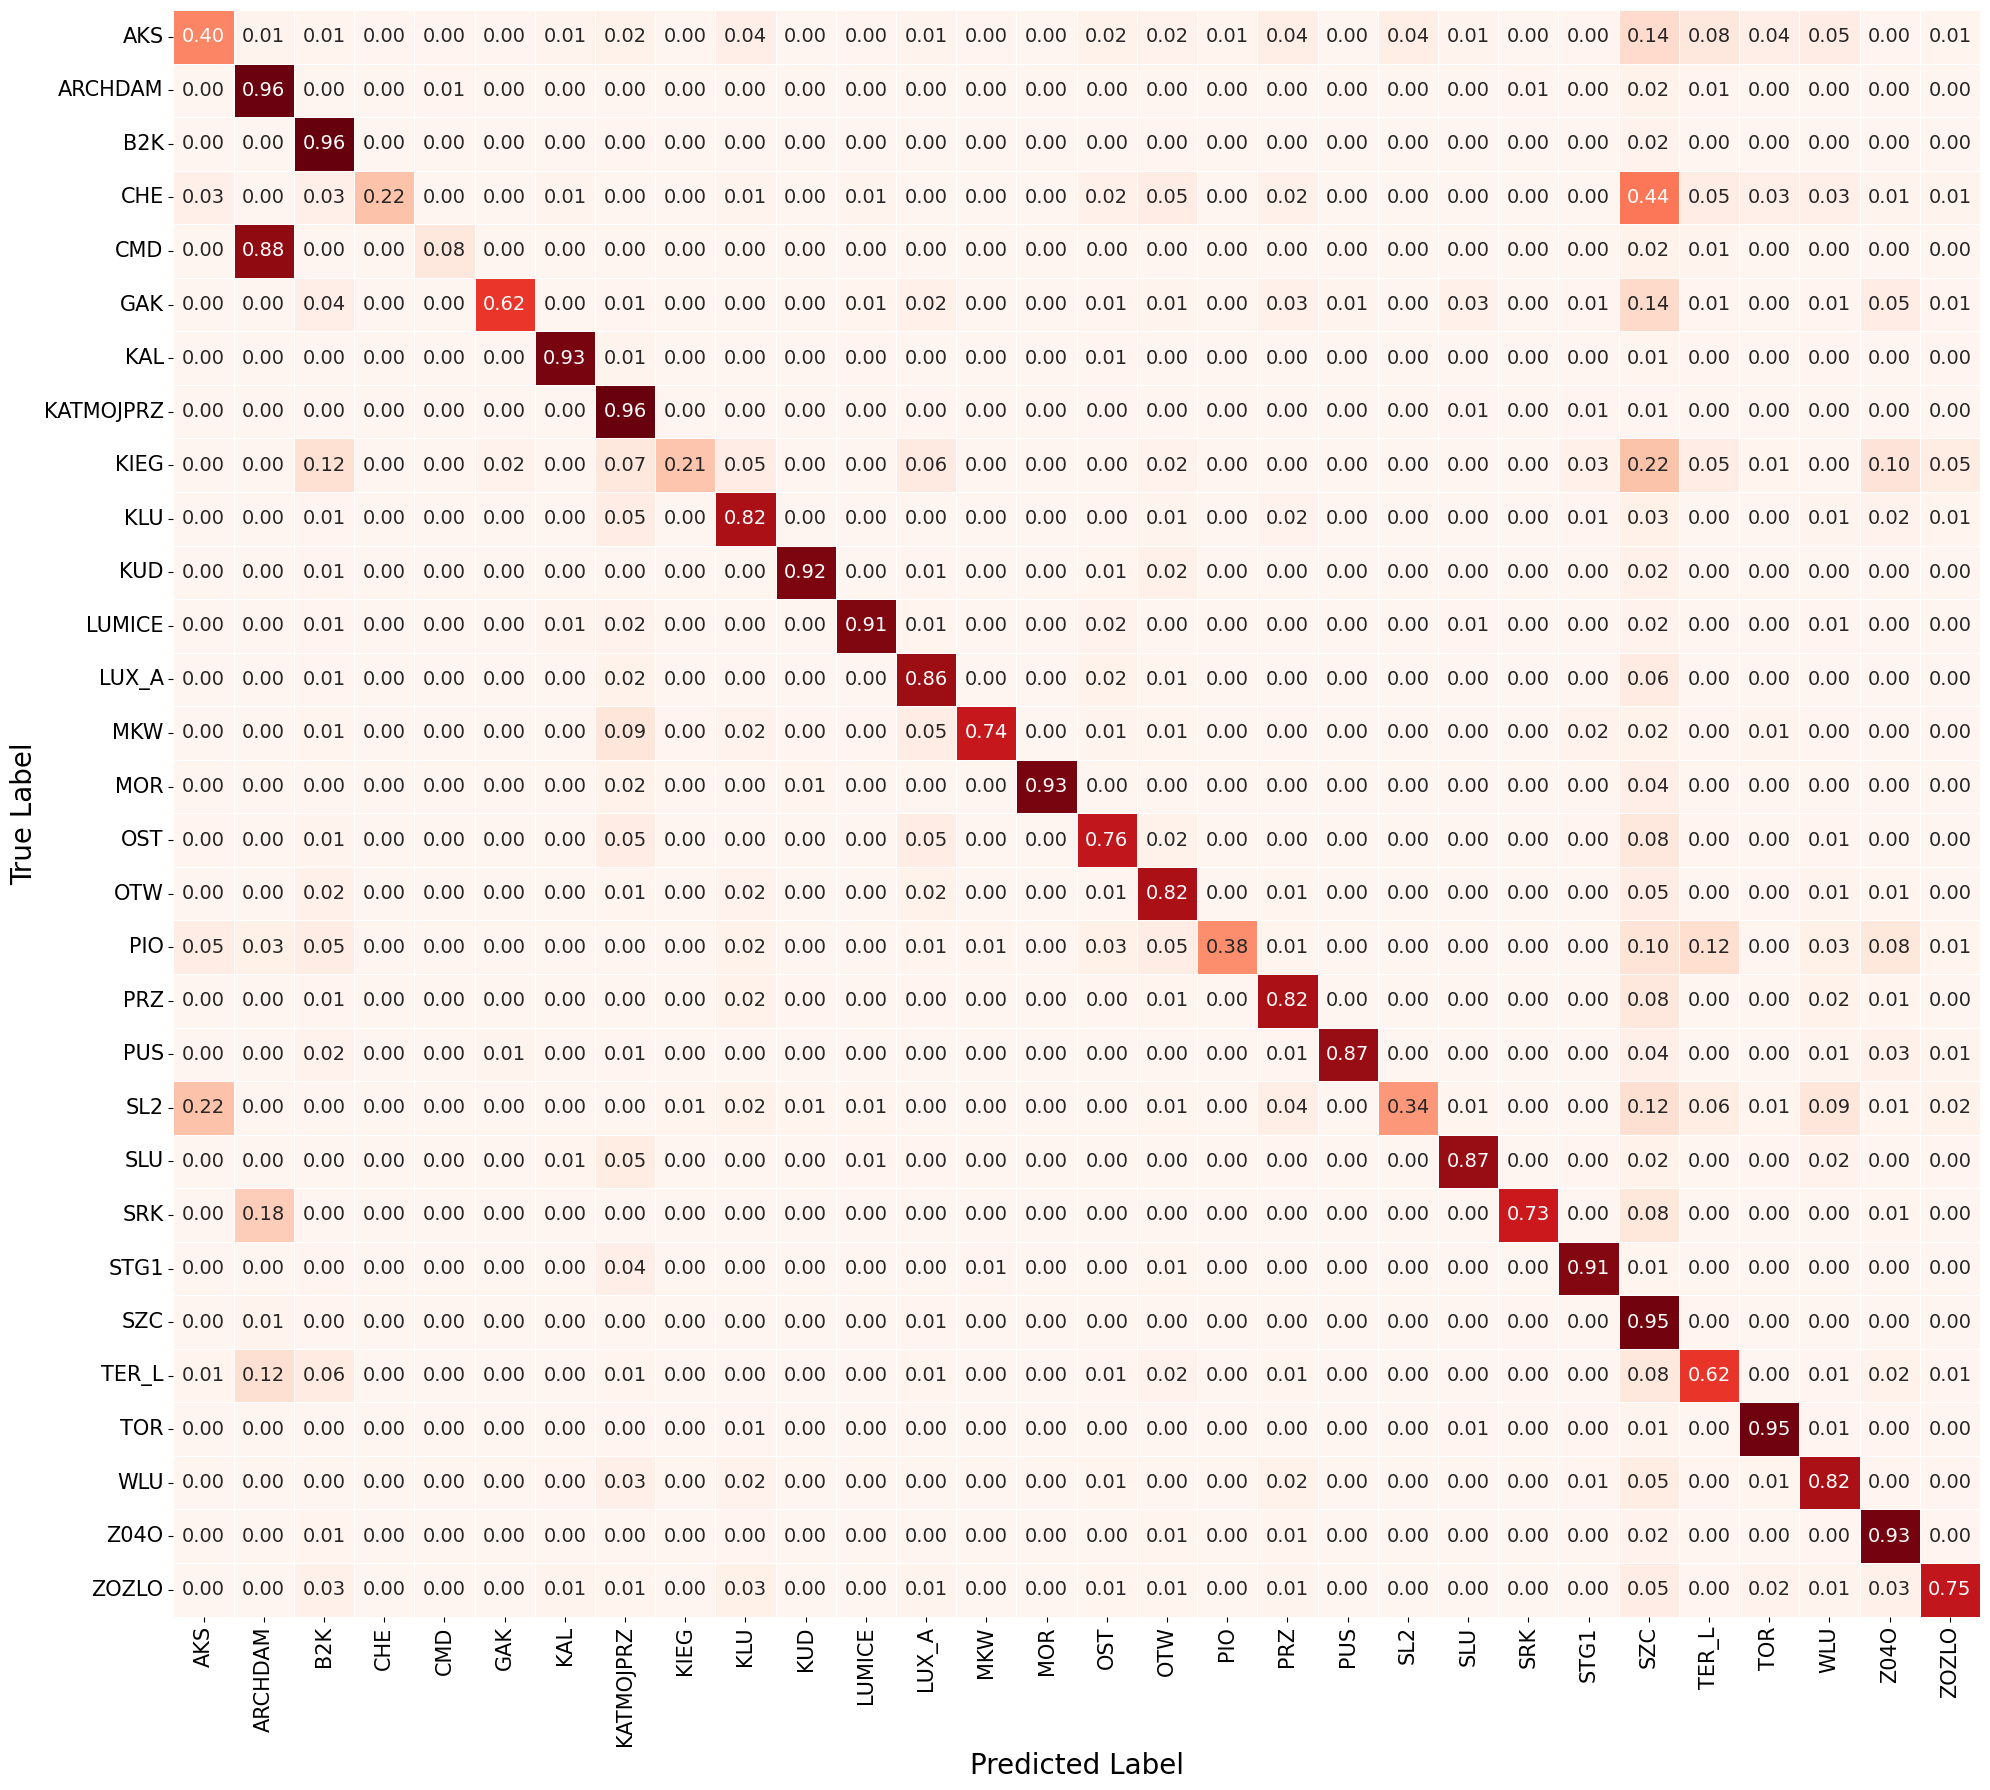

In [15]:
coh_results_df_mean_MCC = save_and_show_results('cov', 'excluded')

# Cov

              Unnamed: 0  mean_value  std_value
0            MCC_Overall    0.751705   0.008917
1               Accuracy    0.776762   0.007944
2      Precision (Macro)    0.740353   0.028912
3   Precision (Weighted)    0.769308   0.007336
4         Recall (Macro)    0.584289   0.012169
5      Recall (Weighted)    0.776762   0.007944
6       F1-Score (Macro)    0.621985   0.010177
7    F1-Score (Weighted)    0.761996   0.008929
8              AUC (OvR)    0.976018   0.002162
9              AUC (OvO)    0.968589   0.002352
10               MCC_AKS    0.349010   0.046606
11           MCC_ARCHDAM    0.813365   0.005794
12               MCC_B2K    0.831128   0.010878
13               MCC_CHE    0.143493   0.132024
14               MCC_CMD    0.200053   0.079920
15               MCC_GAK    0.641827   0.048044
16               MCC_KAL    0.832013   0.031945
17         MCC_KATMOJPRZ    0.834450   0.009303
18              MCC_KIEG    0.072885   0.110032
19               MCC_KLU    0.683597   0

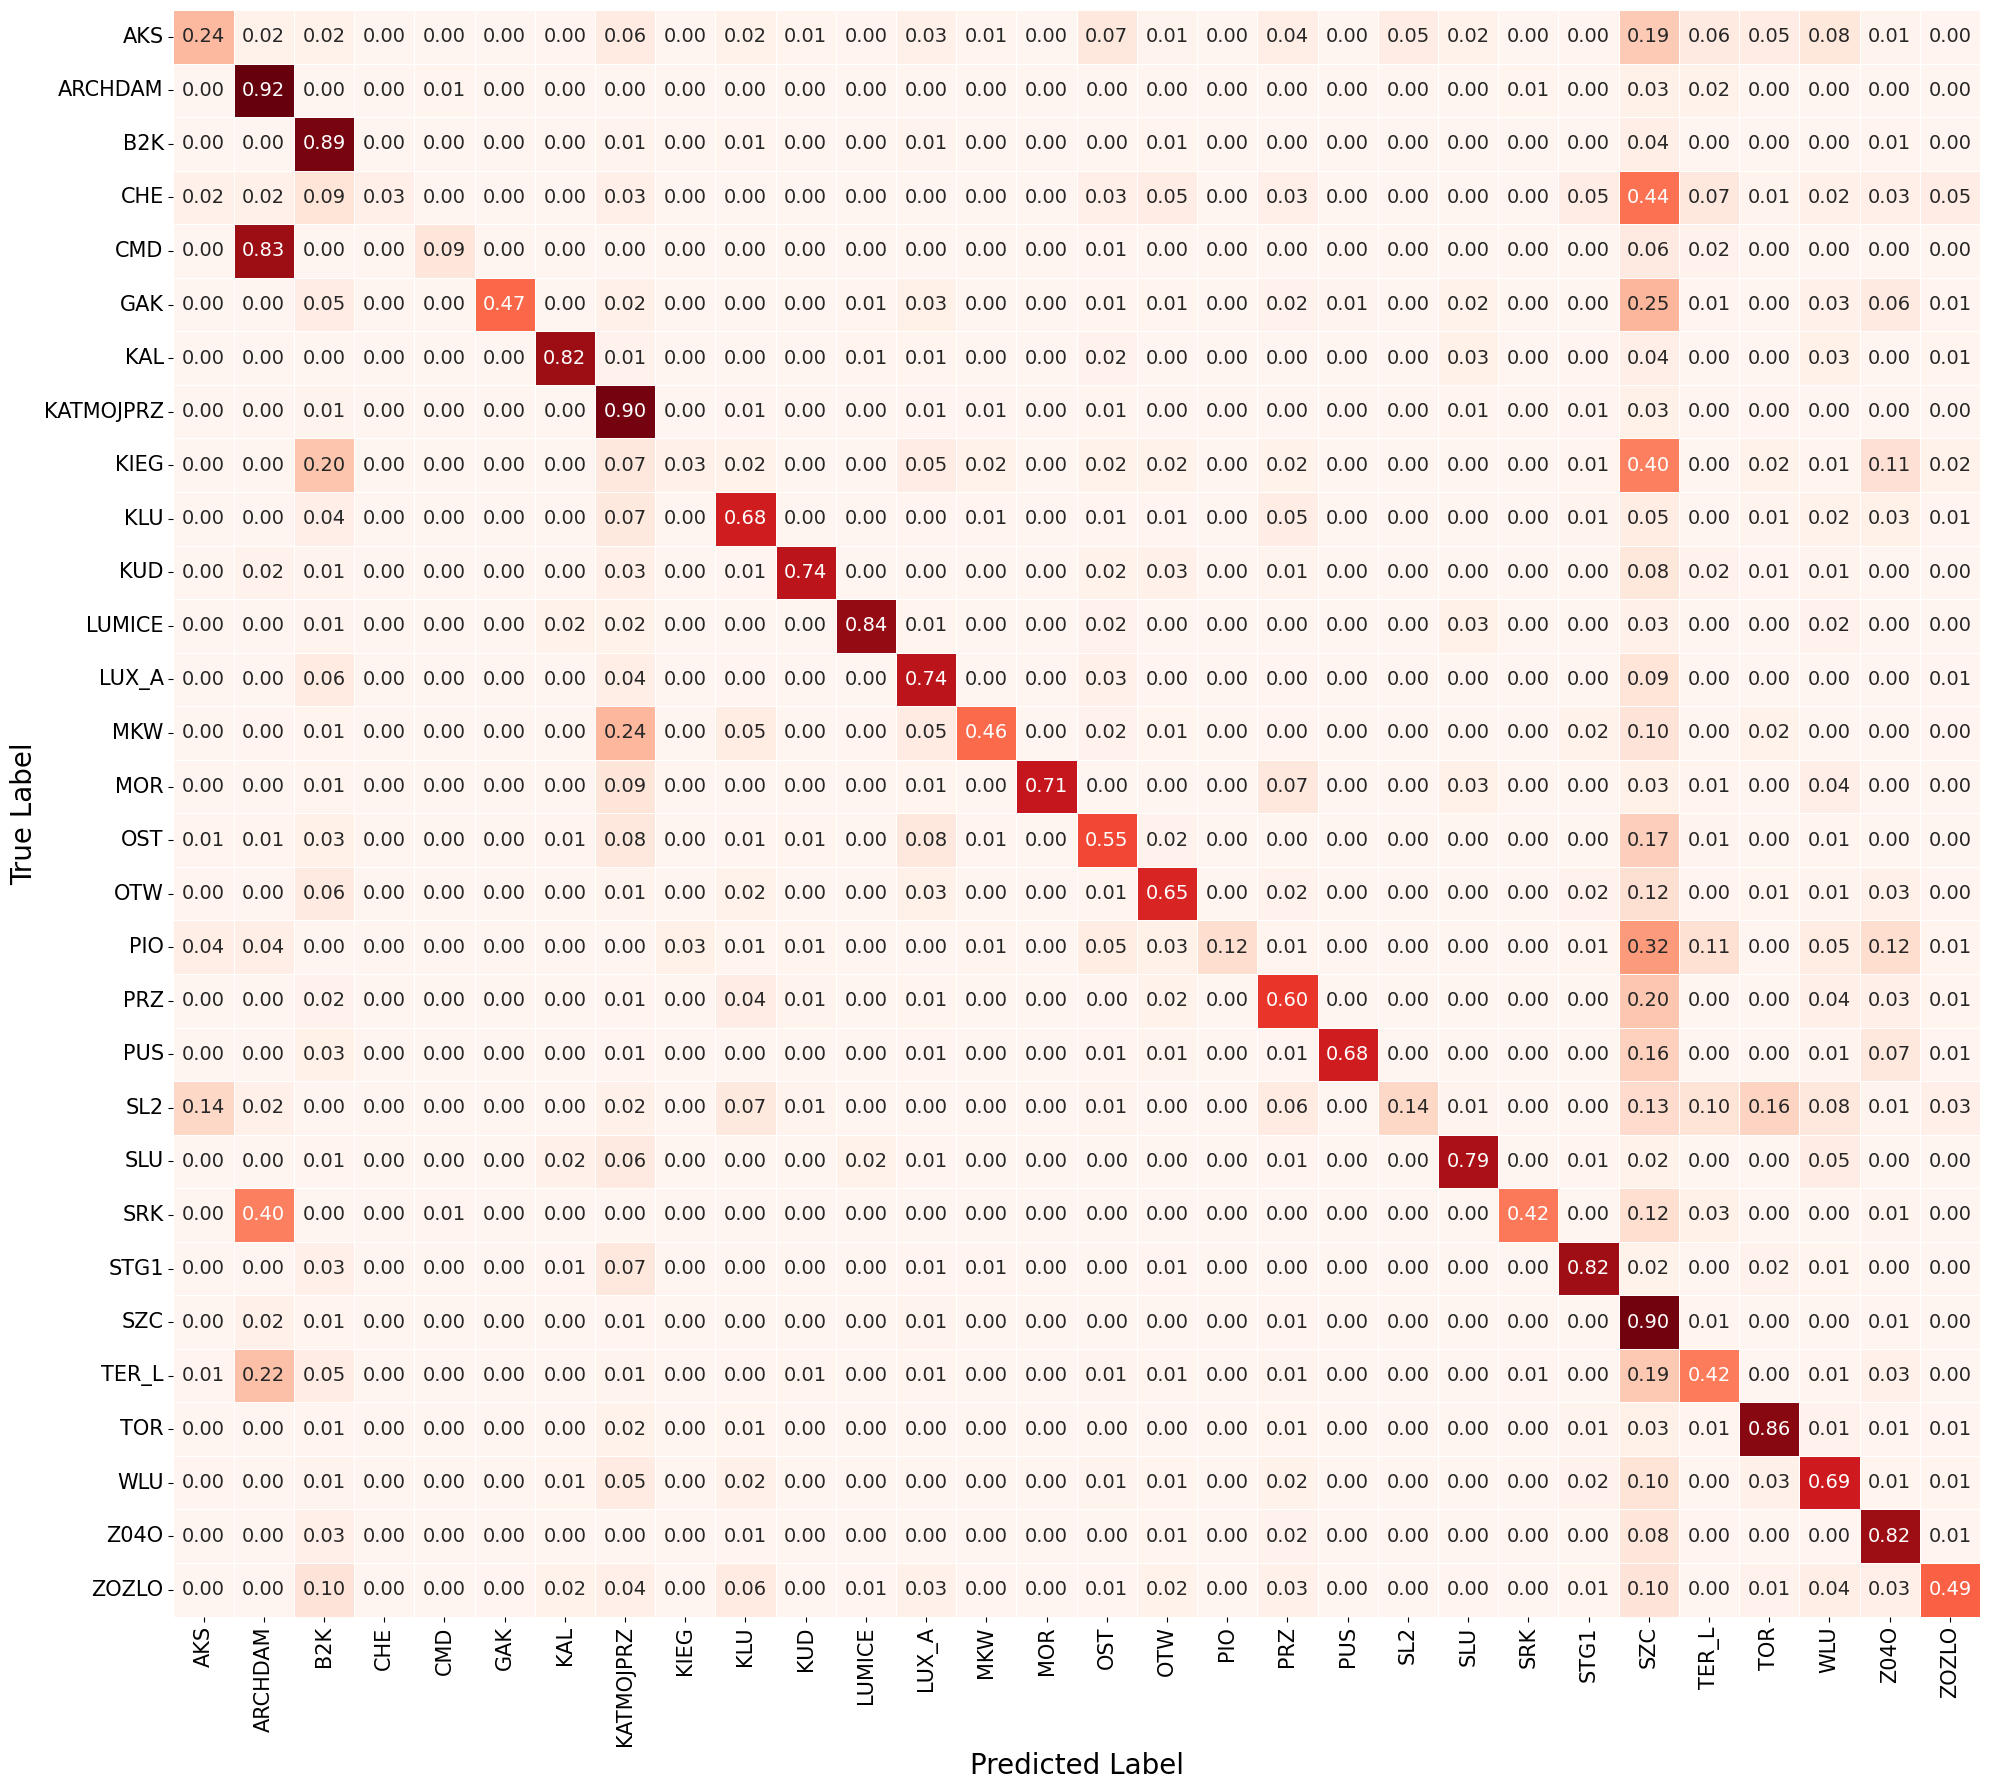

In [16]:
cov_results_df_mean_MCC = save_and_show_results('cov', 'selected')

# Pow

              Unnamed: 0  mean_value  std_value
0            MCC_Overall    0.600476   0.004750
1               Accuracy    0.643142   0.004124
2      Precision (Macro)    0.578998   0.029969
3   Precision (Weighted)    0.626454   0.006615
4         Recall (Macro)    0.400828   0.006320
5      Recall (Weighted)    0.643142   0.004124
6       F1-Score (Macro)    0.440830   0.009660
7    F1-Score (Weighted)    0.619025   0.003622
8              AUC (OvR)    0.943176   0.003071
9              AUC (OvO)    0.926932   0.003301
10               MCC_AKS    0.230965   0.088659
11           MCC_ARCHDAM    0.684303   0.010455
12               MCC_B2K    0.840367   0.016656
13               MCC_CHE    0.048279   0.108389
14               MCC_CMD    0.062072   0.048646
15               MCC_GAK    0.389058   0.033192
16               MCC_KAL    0.629716   0.052077
17         MCC_KATMOJPRZ    0.650748   0.014313
18              MCC_KIEG    0.048869   0.109770
19               MCC_KLU    0.395632   0

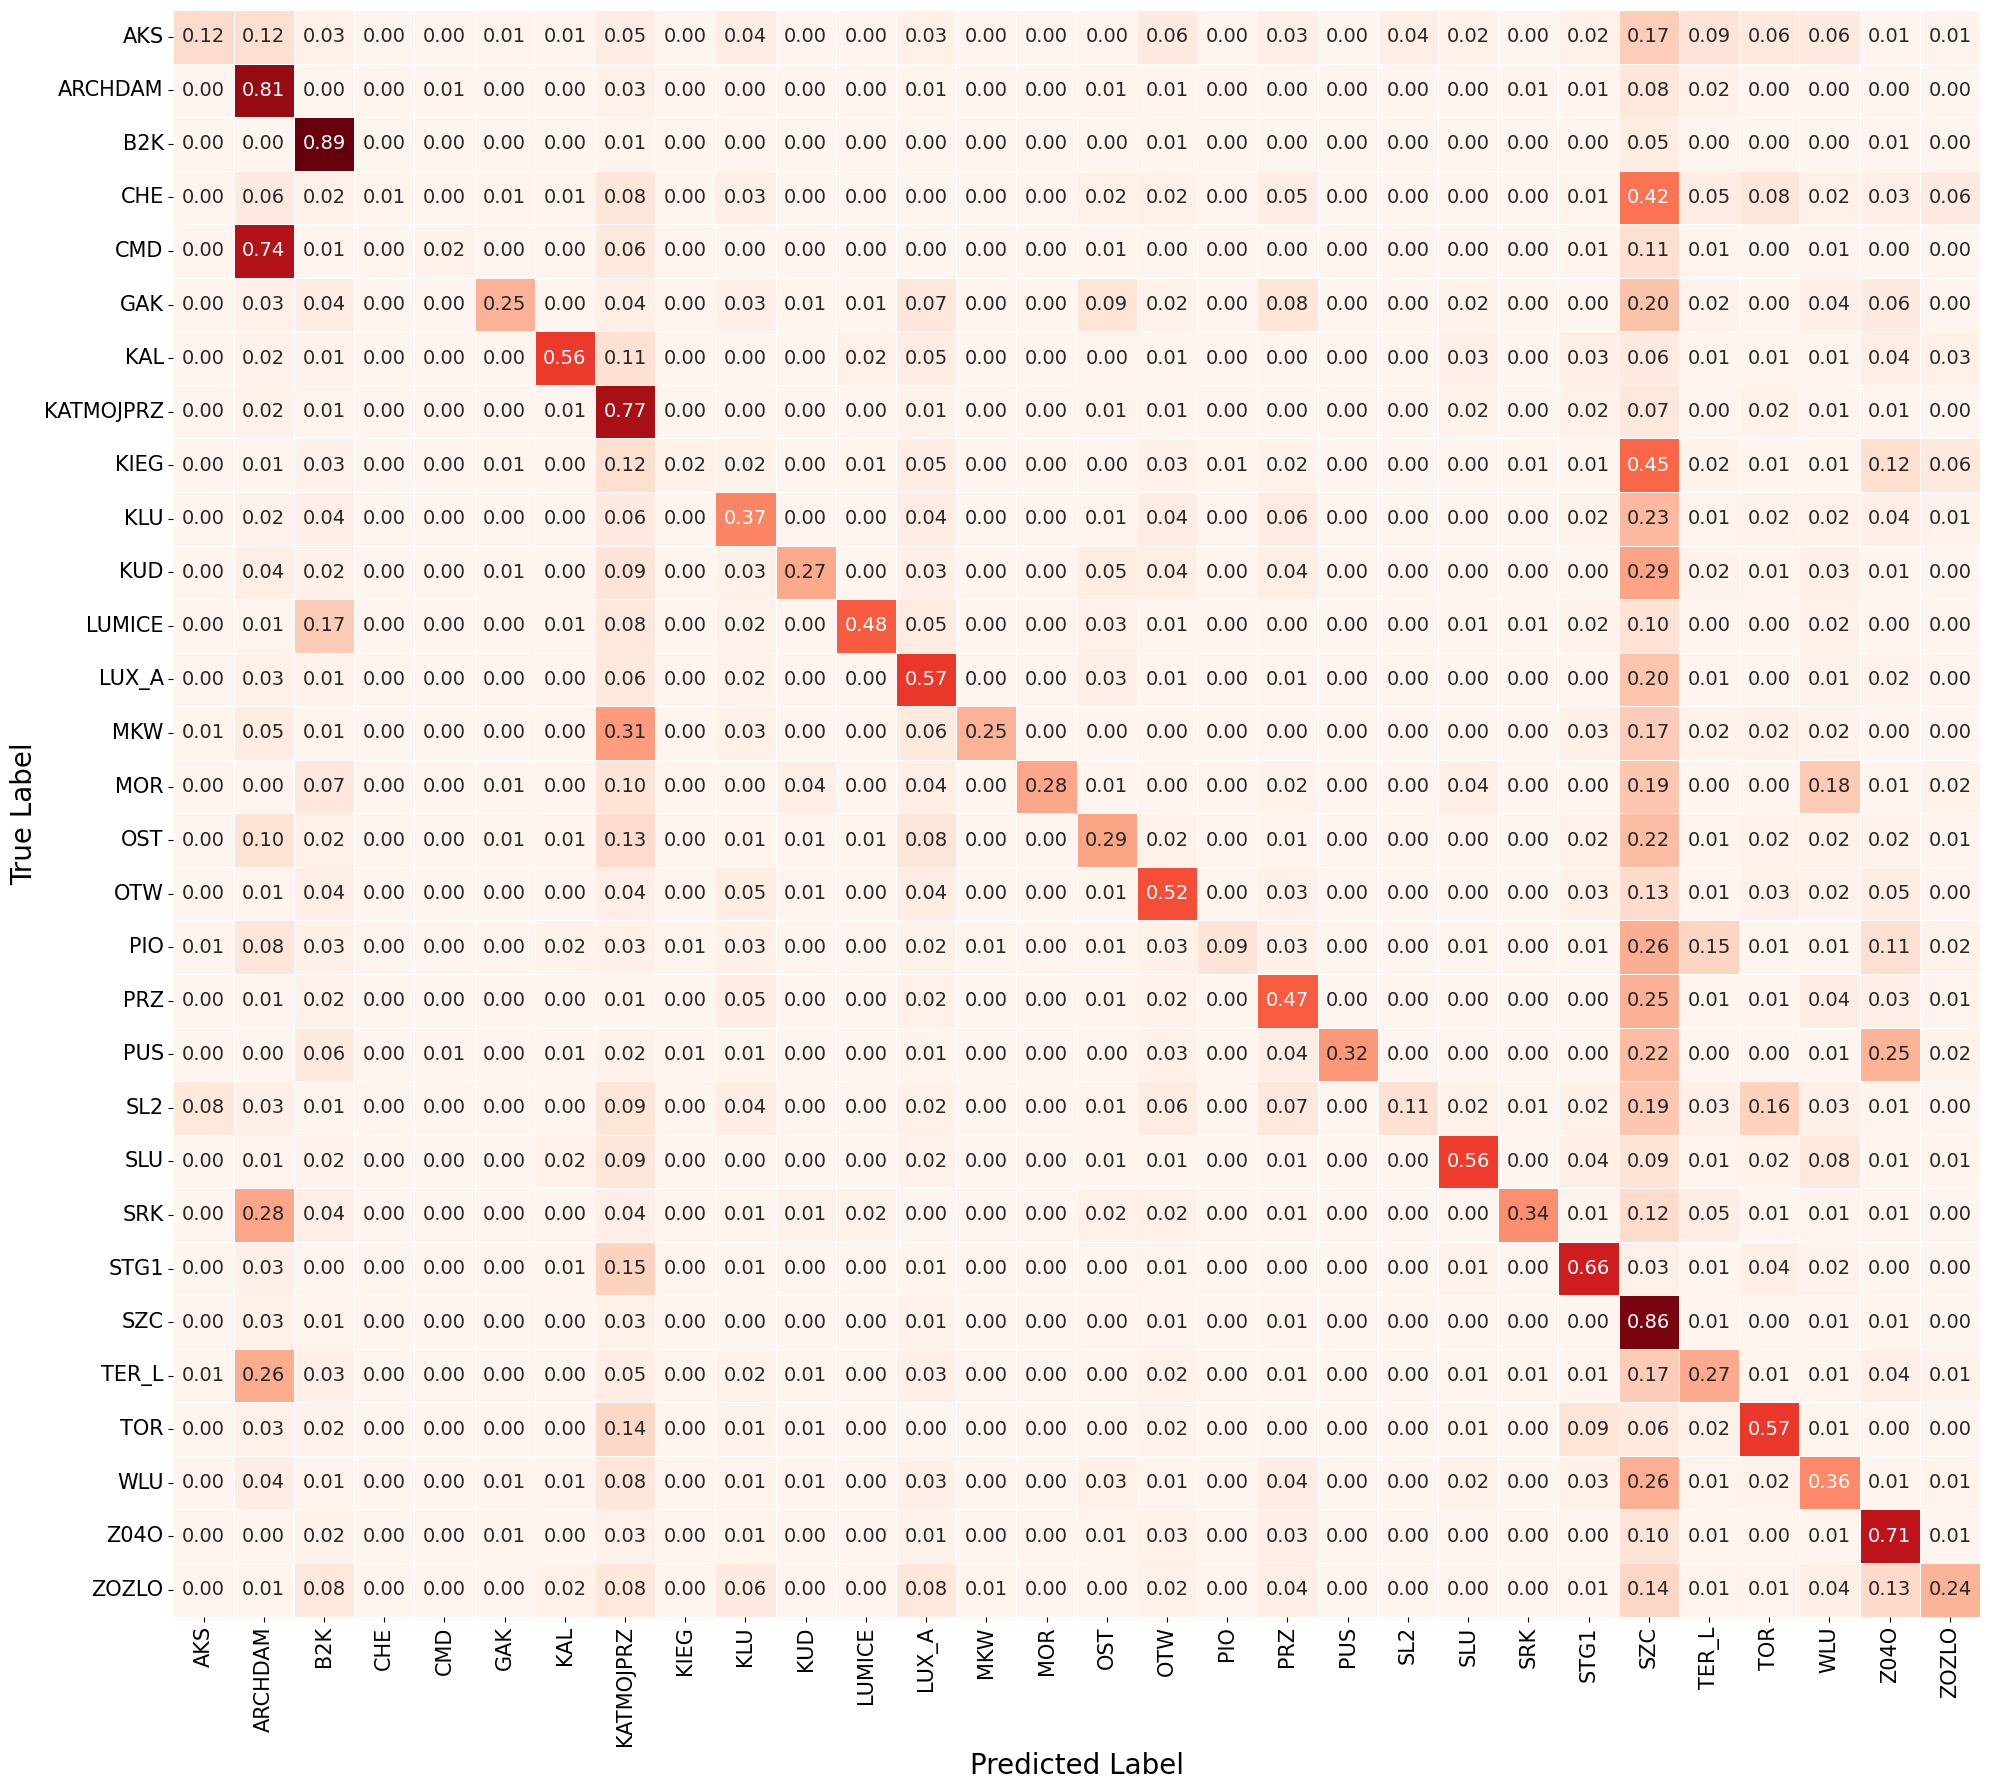

In [17]:
pow_results_df_mean_MCC = save_and_show_results('pow', 'selected')

In [18]:
selected_results_df_mean_MCC = pd.concat([
    coh_results_df_mean_MCC,
    cov_results_df_mean_MCC,
    pow_results_df_mean_MCC
], axis=0, keys=['coh', 'cov', 'pow'])
selected_results_df_mean_MCC.reset_index(level=1, drop=True, inplace=True)


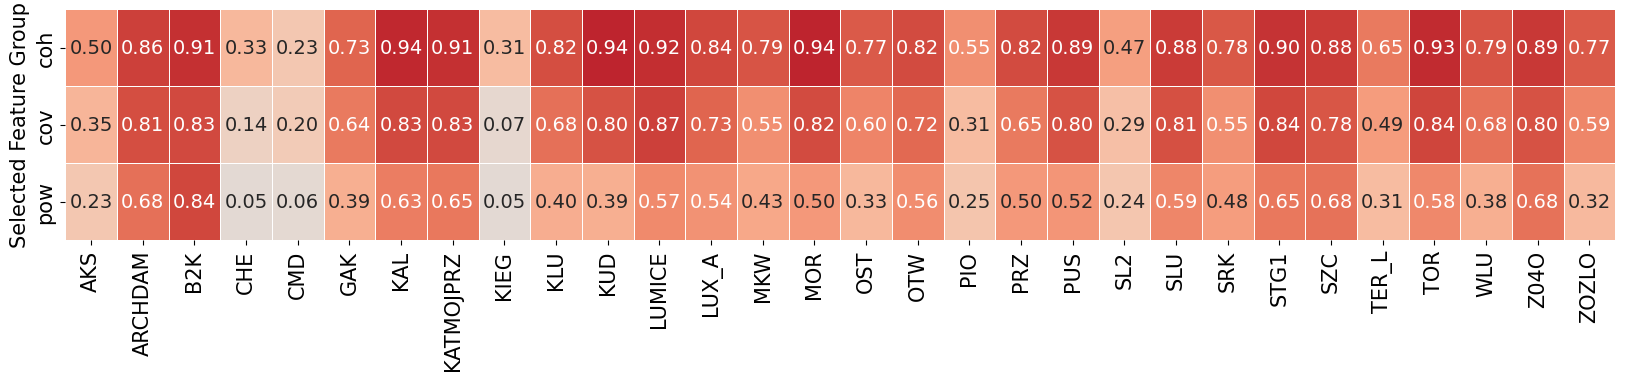

In [19]:
plt.figure(figsize=(20, 3))
ax = sns.heatmap(selected_results_df_mean_MCC, cmap="coolwarm", center=0, vmin=-1, vmax=1, 
            annot=True, fmt=".2f", linewidths=0.5, cbar=False, annot_kws={"size": 14})
ax.set_xticklabels([label.replace("MCC_", "") for label in selected_results_df_mean_MCC.columns], fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
ax.set_ylabel("Selected Feature Group", fontsize=15)
#ax.set_title("Average MCC for Each Class (5-Fold CV)", fontsize=15)
plt.savefig('results/figures/selected_features_group_hospital_classification_avg_mcc_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

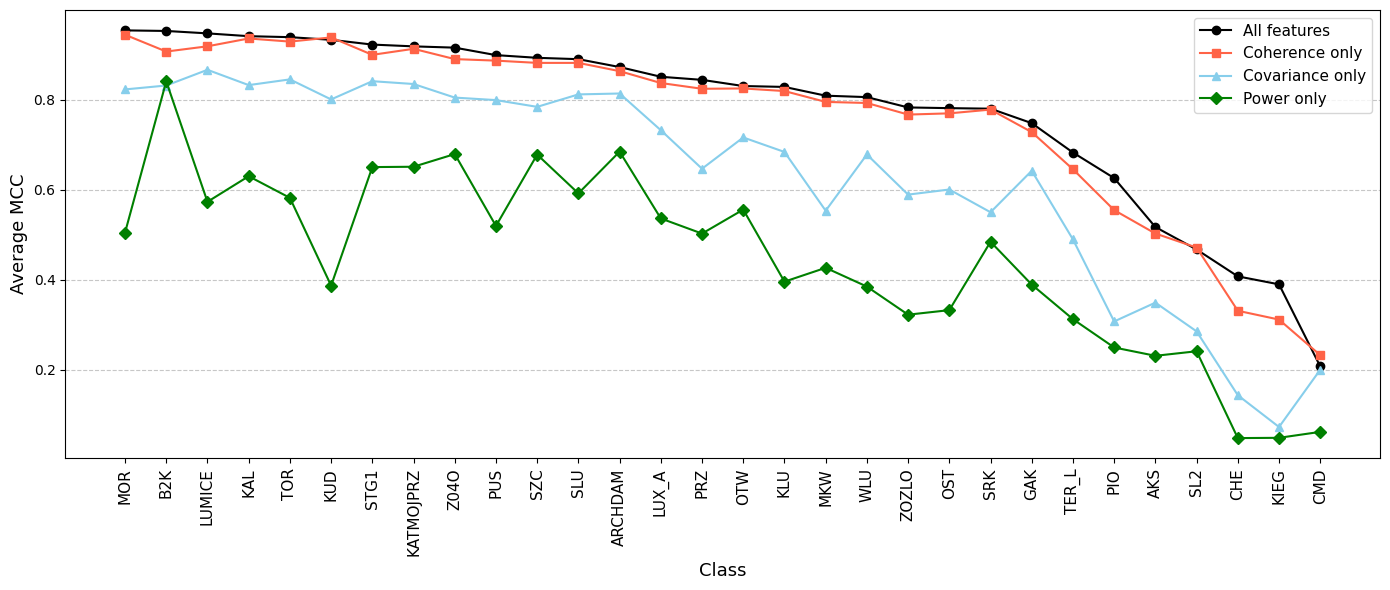

In [54]:
sort_idx = results_df_mean_MCC.values.argsort()[::-1]
class_labels_sorted = class_labels[sort_idx]
all_mcc = results_df_mean_MCC.values[sort_idx]

coh_mcc = selected_results_df_mean_MCC.loc['coh'].values[sort_idx]
cov_mcc = selected_results_df_mean_MCC.loc['cov'].values[sort_idx]
pow_mcc = selected_results_df_mean_MCC.loc['pow'].values[sort_idx]

plt.figure(figsize=(14, 6))
plt.plot(class_labels_sorted, all_mcc, marker='o', linestyle='-', color='black', label='All features')
plt.plot(class_labels_sorted, coh_mcc, marker='s', linestyle='-', color='tomato', label='Coherence only')
plt.plot(class_labels_sorted, cov_mcc, marker='^', linestyle='-', color='skyblue', label='Covariance only')
plt.plot(class_labels_sorted, pow_mcc, marker='D', linestyle='-', color='green', label='Power only')

plt.ylabel("Average MCC", fontsize=13)
plt.xlabel("Class", fontsize=13)
plt.xticks(rotation=90, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=11)
#plt.title("Average MCC per Class Using Different Feature Sets", fontsize=16, weight='bold')
plt.tight_layout()

plt.savefig('results/figures/hospital_classification_mcc_selected_features_notitle.png', dpi=300)
plt.show()

# Excluded

              Unnamed: 0  mean_value  std_value
0            MCC_Overall    0.785215   0.006894
1               Accuracy    0.806572   0.006126
2      Precision (Macro)    0.768993   0.014308
3   Precision (Weighted)    0.798942   0.006745
4         Recall (Macro)    0.616319   0.008376
5      Recall (Weighted)    0.806572   0.006126
6       F1-Score (Macro)    0.653208   0.008712
7    F1-Score (Weighted)    0.793268   0.007067
8              AUC (OvR)    0.981598   0.001771
9              AUC (OvO)    0.973693   0.001920
10               MCC_AKS    0.392528   0.087640
11           MCC_ARCHDAM    0.826703   0.009183
12               MCC_B2K    0.928515   0.011311
13               MCC_CHE    0.129216   0.122152
14               MCC_CMD    0.145250   0.048972
15               MCC_GAK    0.689535   0.043405
16               MCC_KAL    0.854451   0.038102
17         MCC_KATMOJPRZ    0.856145   0.012825
18              MCC_KIEG    0.183775   0.130947
19               MCC_KLU    0.681445   0

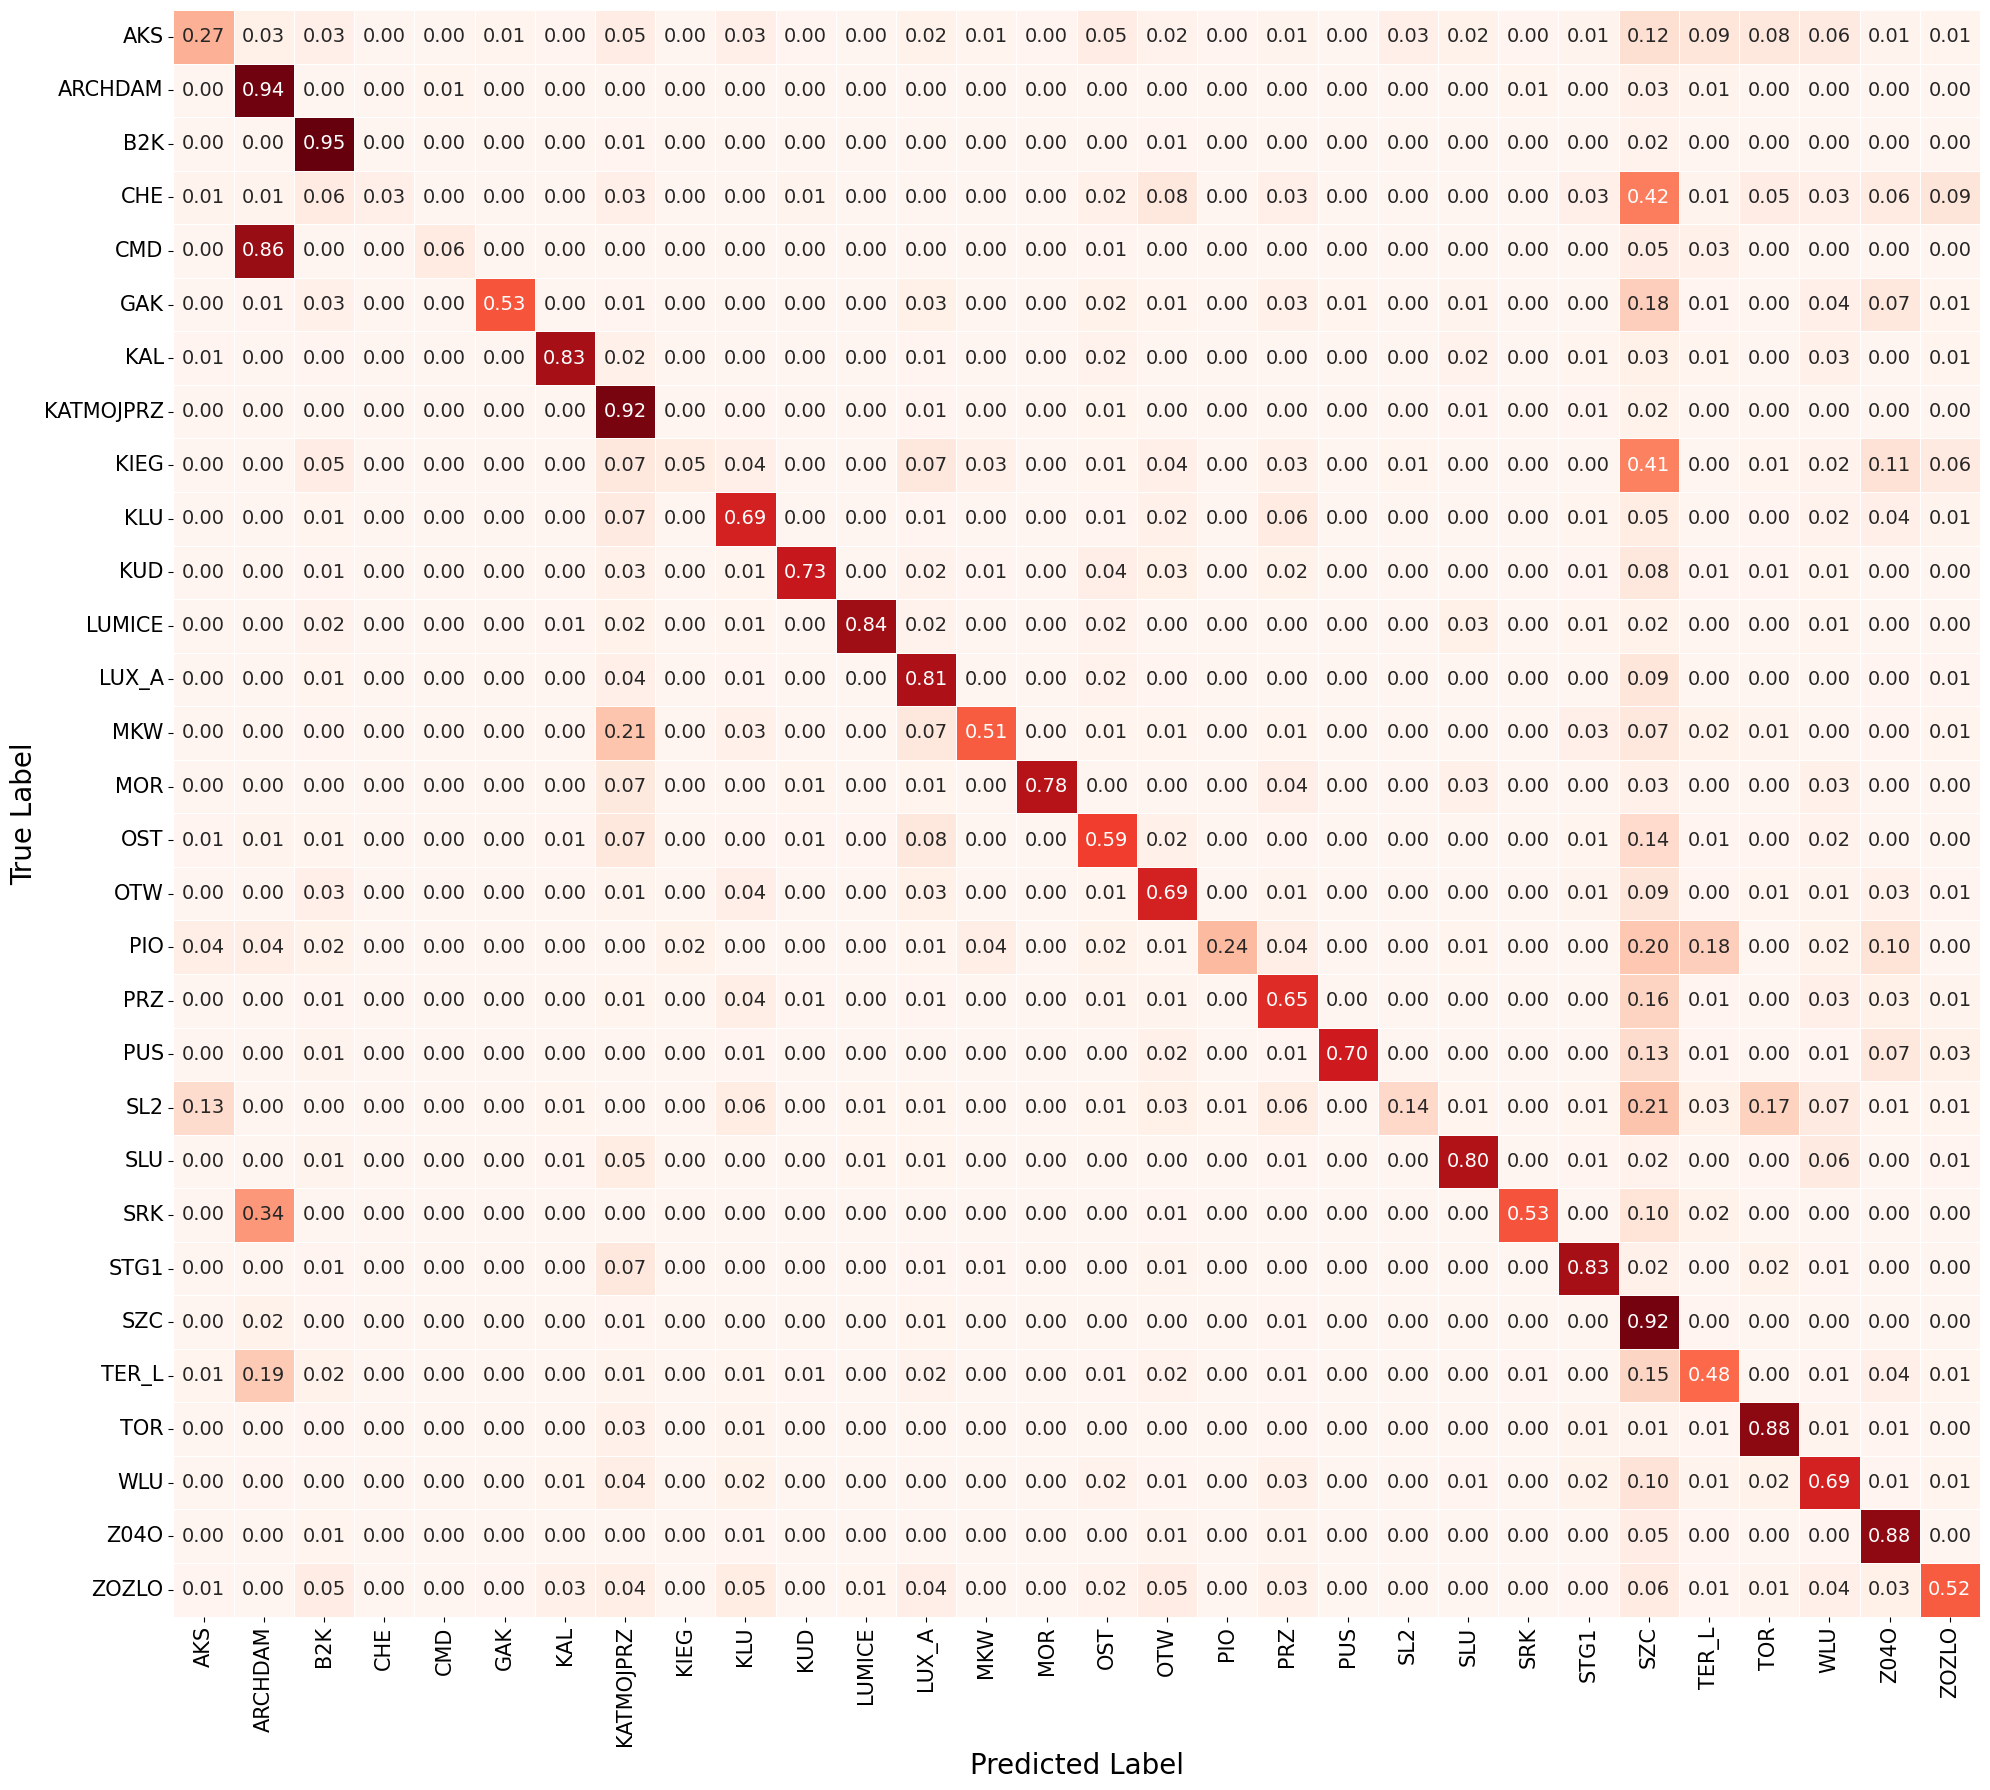

In [46]:
excluded_coh_results_df_mean_MCC = save_and_show_results('coh', 'excluded')

              Unnamed: 0  mean_value  std_value
0            MCC_Overall    0.863086   0.003757
1               Accuracy    0.876317   0.003377
2      Precision (Macro)    0.862442   0.021898
3   Precision (Weighted)    0.872921   0.004498
4         Recall (Macro)    0.735301   0.010973
5      Recall (Weighted)    0.876317   0.003377
6       F1-Score (Macro)    0.769087   0.012356
7    F1-Score (Weighted)    0.867922   0.003869
8              AUC (OvR)    0.992011   0.000840
9              AUC (OvO)    0.987824   0.001133
10               MCC_AKS    0.513854   0.112846
11           MCC_ARCHDAM    0.867770   0.006037
12               MCC_B2K    0.937599   0.009751
13               MCC_CHE    0.421603   0.087787
14               MCC_CMD    0.208199   0.055026
15               MCC_GAK    0.753223   0.026824
16               MCC_KAL    0.931987   0.023113
17         MCC_KATMOJPRZ    0.919647   0.007467
18              MCC_KIEG    0.421475   0.039643
19               MCC_KLU    0.821397   0

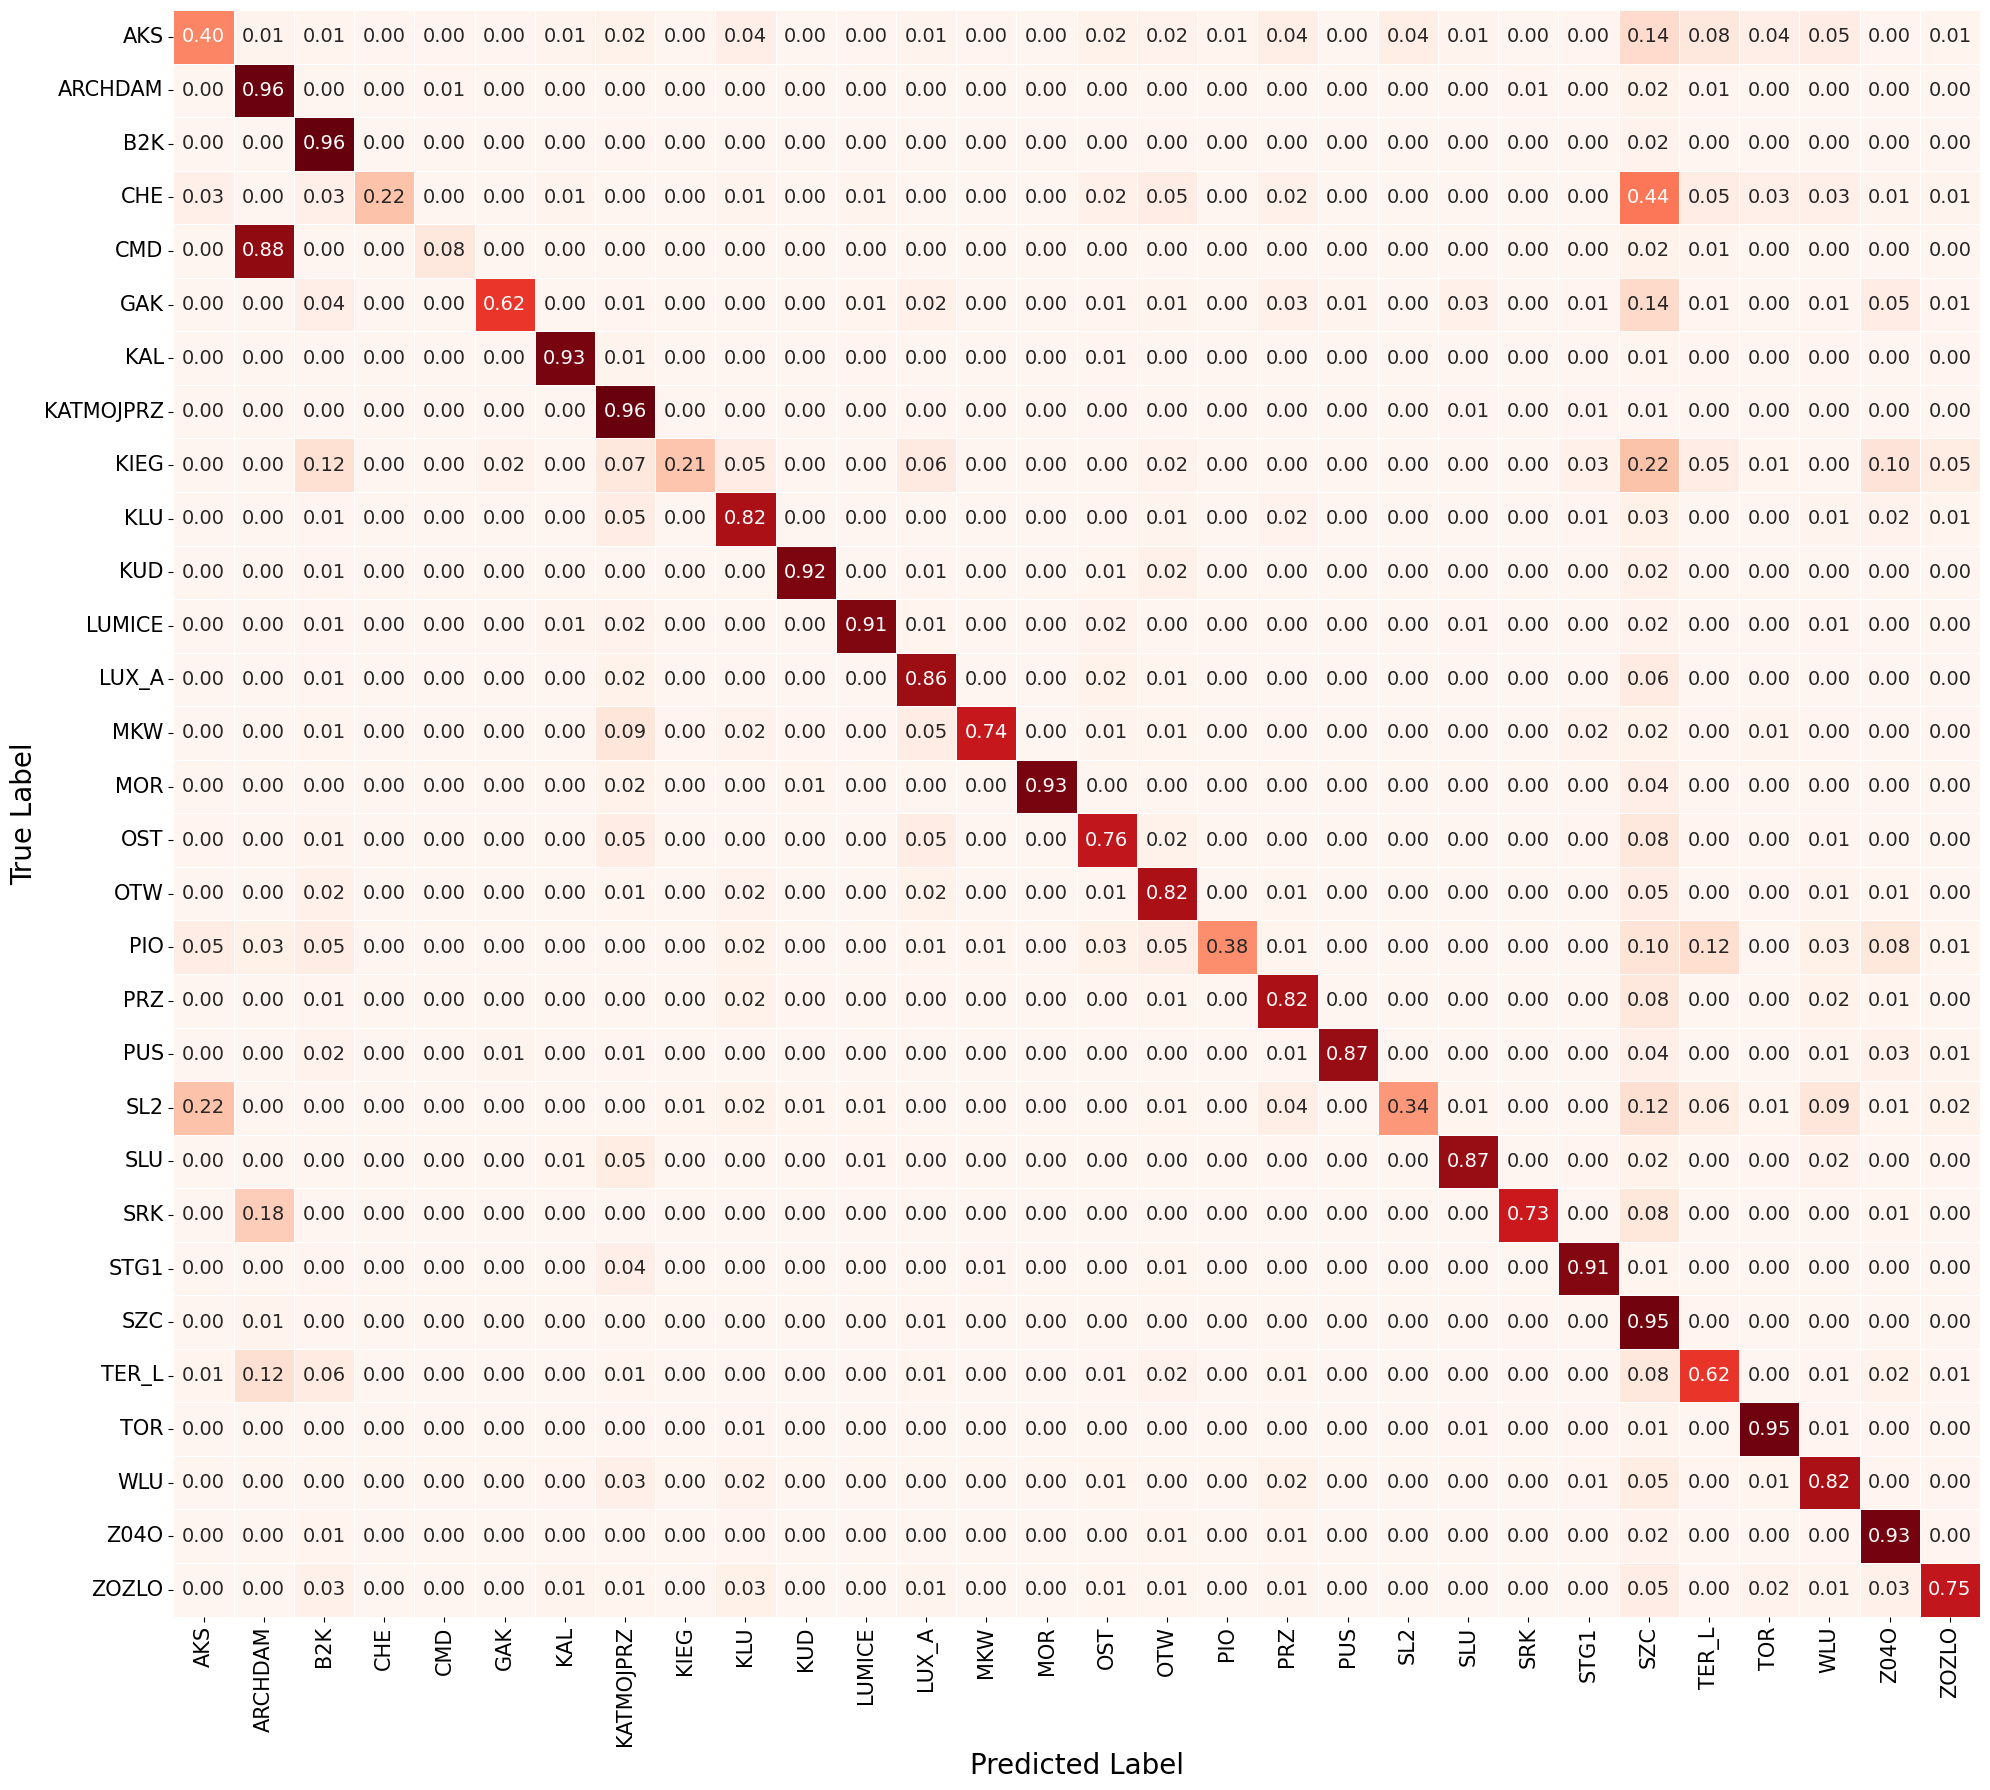

In [47]:
excluded_cov_results_df_mean_MCC = save_and_show_results('cov', 'excluded')

              Unnamed: 0  mean_value  std_value
0            MCC_Overall    0.857449   0.002472
1               Accuracy    0.871274   0.002219
2      Precision (Macro)    0.850698   0.020245
3   Precision (Weighted)    0.866960   0.003494
4         Recall (Macro)    0.728922   0.005584
5      Recall (Weighted)    0.871274   0.002219
6       F1-Score (Macro)    0.761590   0.007327
7    F1-Score (Weighted)    0.863009   0.001860
8              AUC (OvR)    0.991874   0.001297
9              AUC (OvO)    0.987716   0.001698
10               MCC_AKS    0.512193   0.098895
11           MCC_ARCHDAM    0.869737   0.009099
12               MCC_B2K    0.931349   0.008656
13               MCC_CHE    0.379807   0.116475
14               MCC_CMD    0.212364   0.051728
15               MCC_GAK    0.736904   0.057334
16               MCC_KAL    0.923470   0.024969
17         MCC_KATMOJPRZ    0.916076   0.007886
18              MCC_KIEG    0.345189   0.090749
19               MCC_KLU    0.812666   0

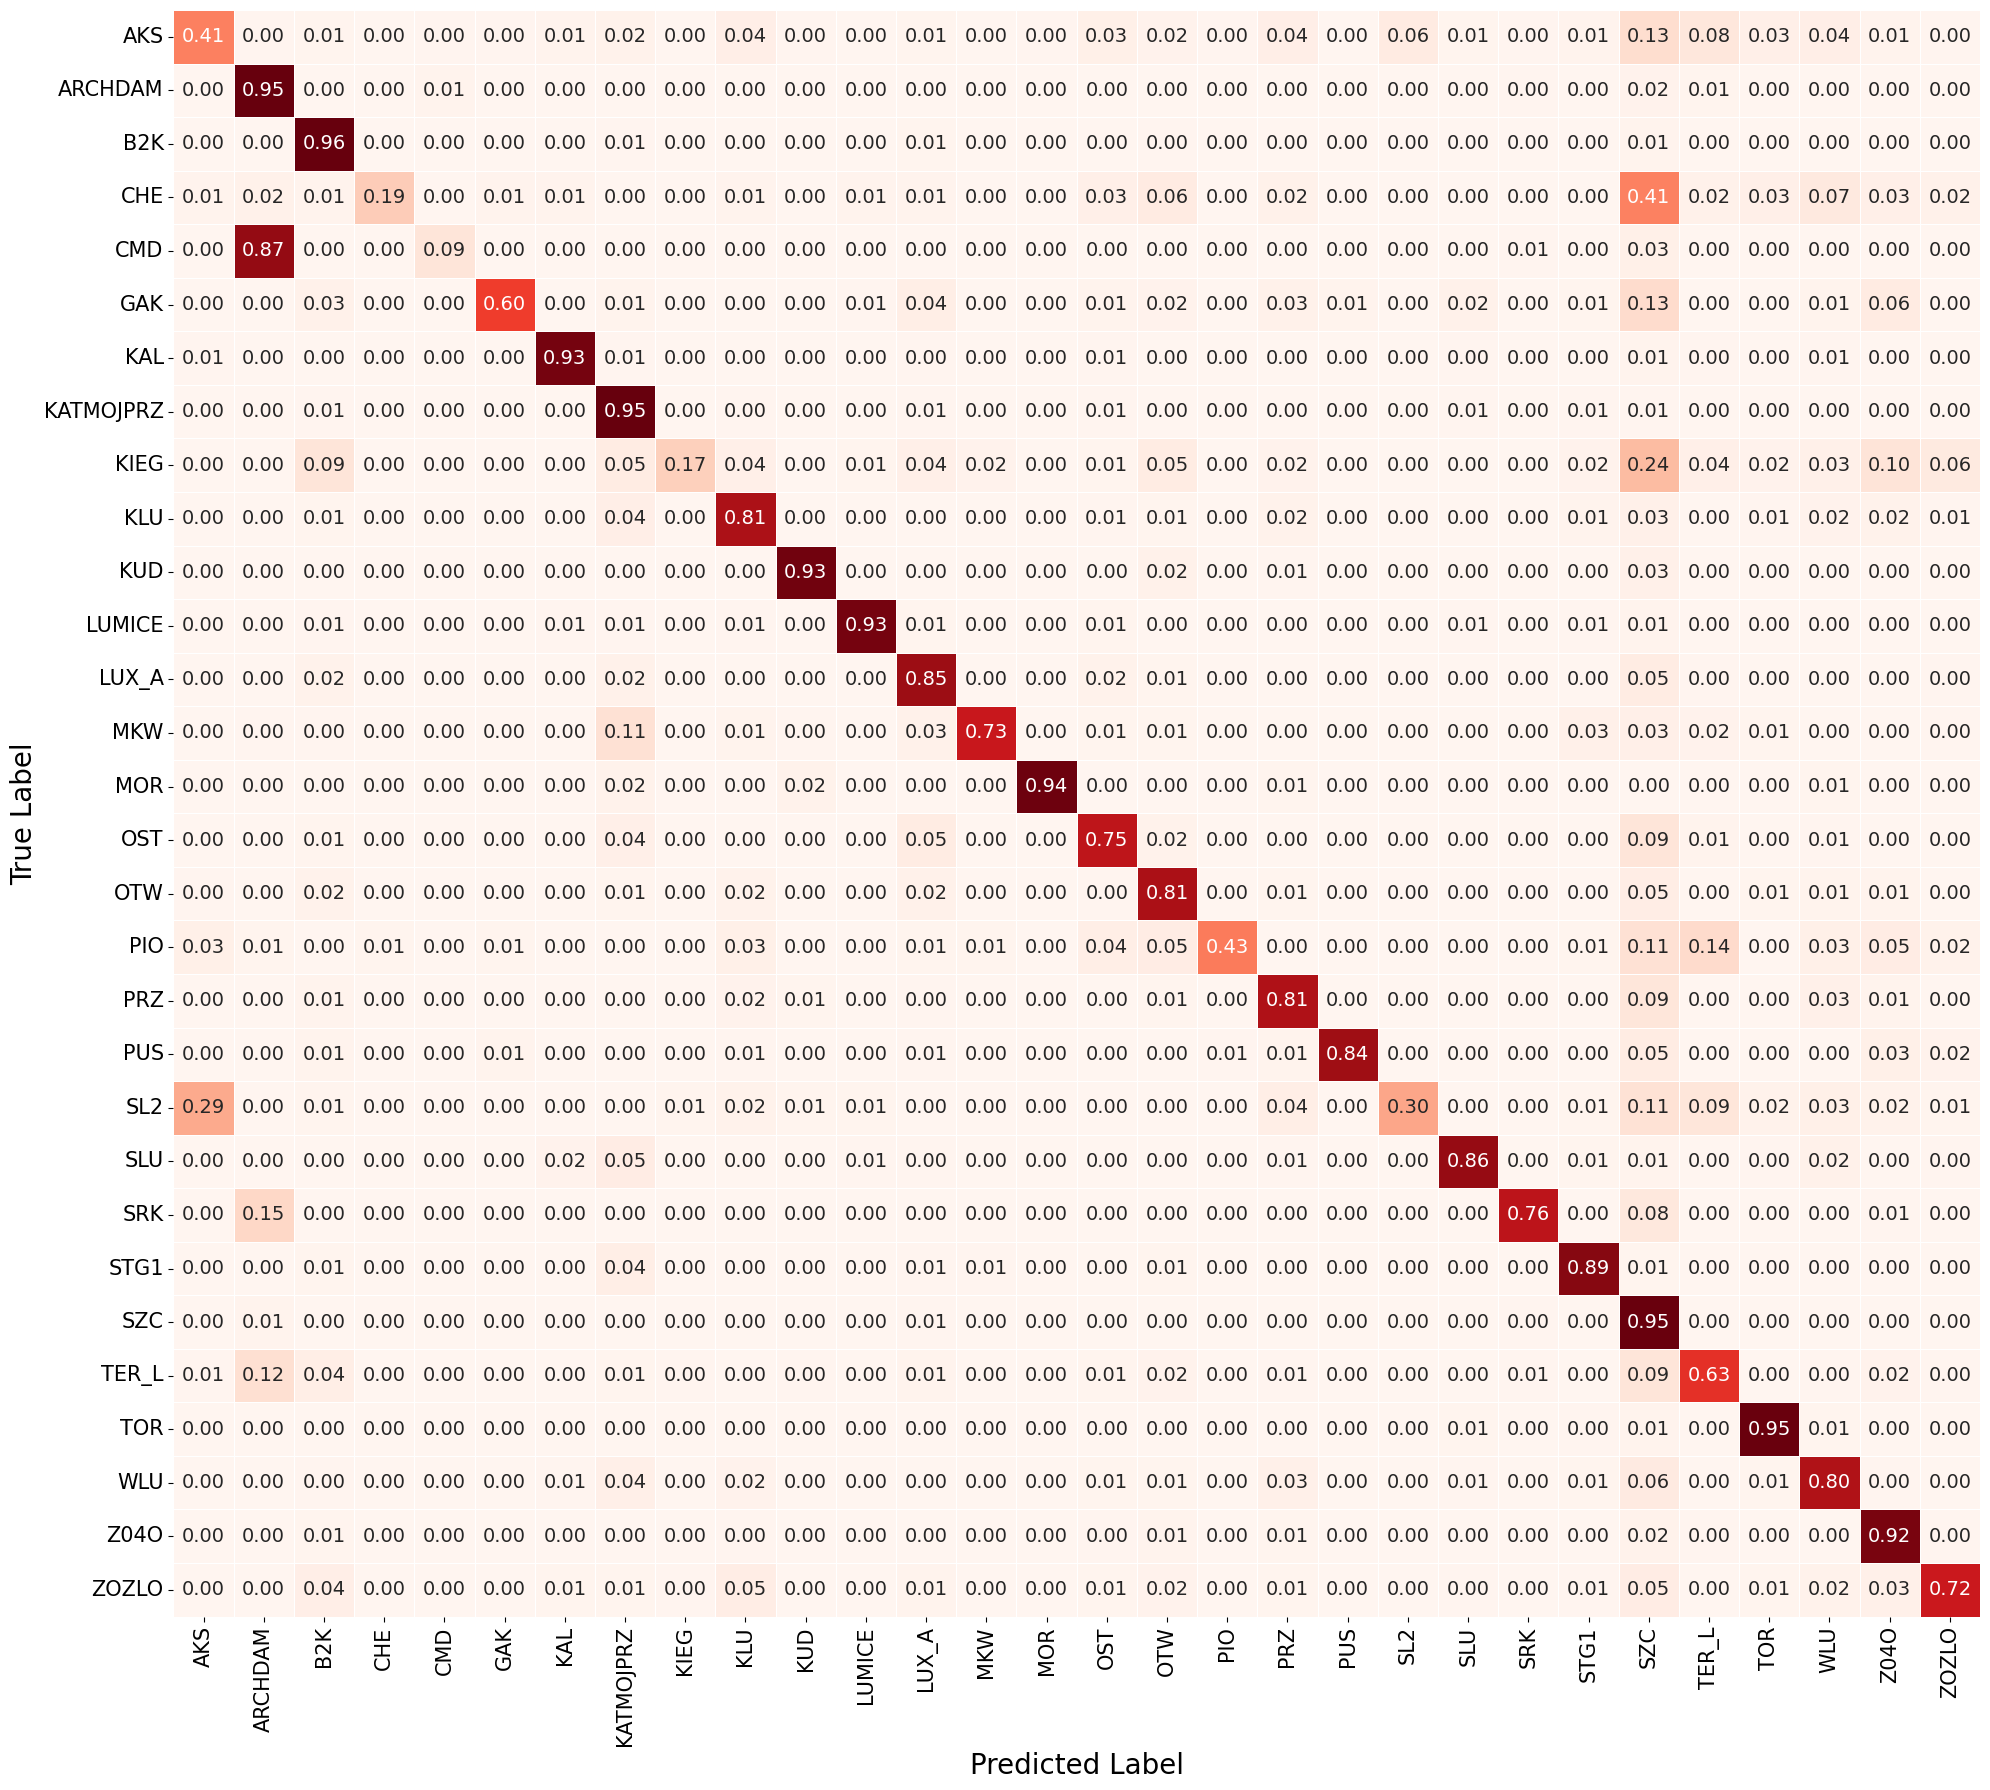

In [48]:
excluded_pow_results_df_mean_MCC = save_and_show_results('pow', 'excluded')

In [49]:
excluded_results_df_mean_MCC = pd.concat([
    excluded_coh_results_df_mean_MCC,
    excluded_cov_results_df_mean_MCC,
    excluded_pow_results_df_mean_MCC
], axis=0, keys=['coh', 'cov', 'pow'])
excluded_results_df_mean_MCC.reset_index(level=1, drop=True, inplace=True)


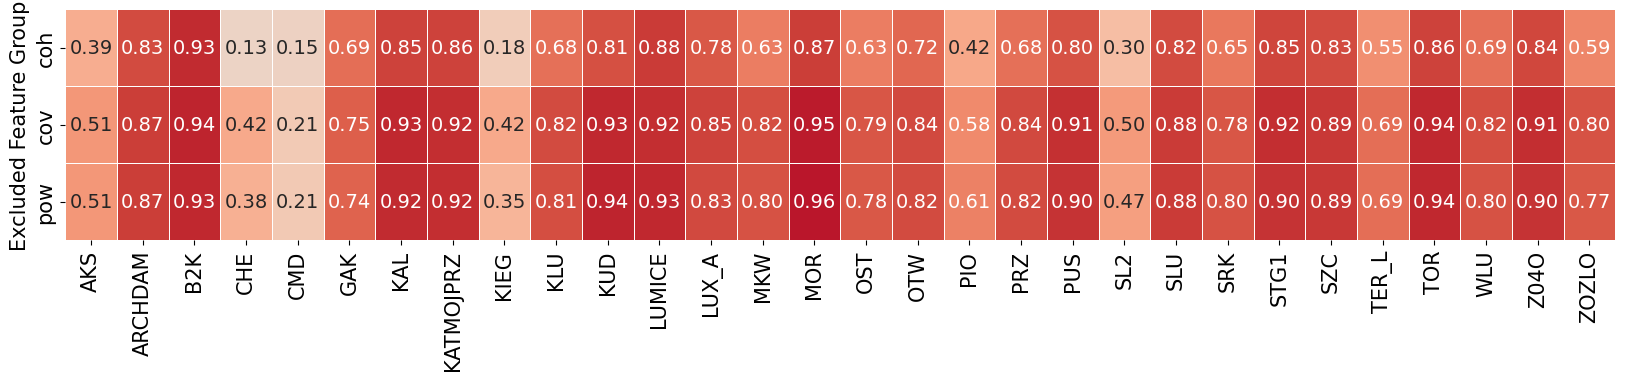

In [50]:
plt.figure(figsize=(20, 3))
ax = sns.heatmap(excluded_results_df_mean_MCC, cmap="coolwarm", center=0, vmin=-1, vmax=1, 
            annot=True, fmt=".2f", linewidths=0.5, cbar=False, annot_kws={"size": 14})
ax.set_xticklabels([label.replace("MCC_", "") for label in excluded_results_df_mean_MCC.columns], fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)
#ax.set_title("Average MCC for Each Class (5-Fold CV)", fontsize=15)
ax.set_ylabel("Excluded Feature Group", fontsize=15)
plt.savefig('results/figures/excluded_features_group_hospital_classification_avg_mcc_per_class.png', dpi=300, bbox_inches='tight')
plt.show()

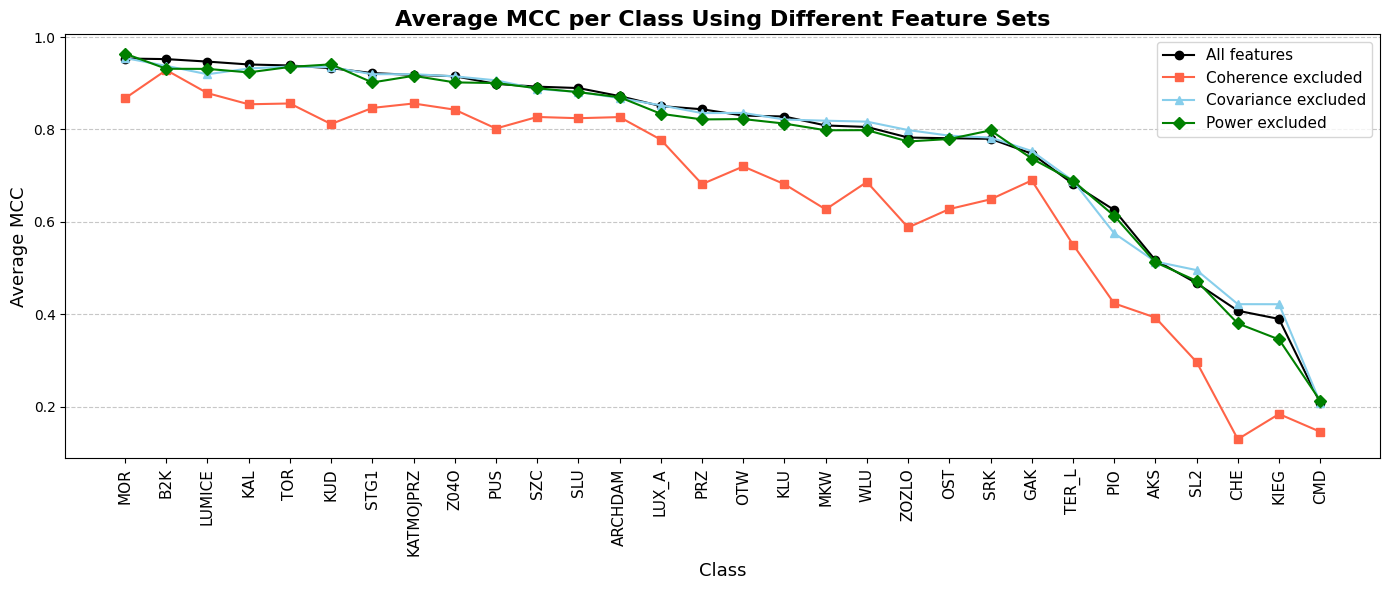

In [56]:
sort_idx = results_df_mean_MCC.values.argsort()[::-1]
class_labels_sorted = class_labels[sort_idx]
all_mcc = results_df_mean_MCC.values[sort_idx]

coh_mcc = excluded_results_df_mean_MCC.loc['coh'].values[sort_idx]
cov_mcc = excluded_results_df_mean_MCC.loc['cov'].values[sort_idx]
pow_mcc = excluded_results_df_mean_MCC.loc['pow'].values[sort_idx]

plt.figure(figsize=(14, 6))
plt.plot(class_labels_sorted, all_mcc, marker='o', linestyle='-', color='black', label='All features')
plt.plot(class_labels_sorted, coh_mcc, marker='s', linestyle='-', color='tomato', label='Coherence excluded')
plt.plot(class_labels_sorted, cov_mcc, marker='^', linestyle='-', color='skyblue', label='Covariance excluded')
plt.plot(class_labels_sorted, pow_mcc, marker='D', linestyle='-', color='green', label='Power excluded')

plt.ylabel("Average MCC", fontsize=13)
plt.xlabel("Class", fontsize=13)
plt.xticks(rotation=90, fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right', fontsize=11)
plt.title("Average MCC per Class Using Different Feature Sets", fontsize=16, weight='bold')
plt.tight_layout()

plt.savefig('results/figures/hospital_classification_mcc_excluded_features.png', dpi=300)
plt.show()